In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

import acoutreams

k0 = 2 * np.pi * 150000 / 343
materials = [acoutreams.AcousticMaterial(1050 + 100j, 2350 - 300j), acoutreams.AcousticMaterial(998, 1497)]
lmax = 3
radii = [0.005, 0.005]
positions = np.array(
    [
        [0.01, 0, 0],
        [-0.01, 0, 0],
    ]
)

spheres = [acoutreams.AcousticTMatrix.sphere(lmax, k0, r, materials) for r in radii]
tm = acoutreams.AcousticTMatrix.cluster(spheres, positions).interaction.solve()
inc = acoutreams.plane_wave_scalar([0, 0, tm.k0], k0=tm.k0, material=tm.material)
sca = tm.sca(inc)
xs = tm.xs(inc)

AttributeError: module 'acoutreams' has no attribute 'TMatrix'

In [ ]:
x = np.linspace(-0.015, 0.015, 101)
z = np.linspace(-0.015, 0.015, 101)
def compute_intensity(i, j):
    r = [x[j], 0, z[i]]
    result = 0  
    if tm.valid_points(r, radii): 
        result = 0.5 * np.abs(inc.pfield(r) + sca.pfield(r))**2  
    else:
        result = np.nan
    return i, j, result  
results = Parallel(n_jobs=-1)(
    delayed(compute_intensity)(i, j) for i in range(len(z)) for j in range(len(x))
)
intensity = np.zeros((len(z), len(x)))
for i, j, result in results:
    intensity[i, j] = result

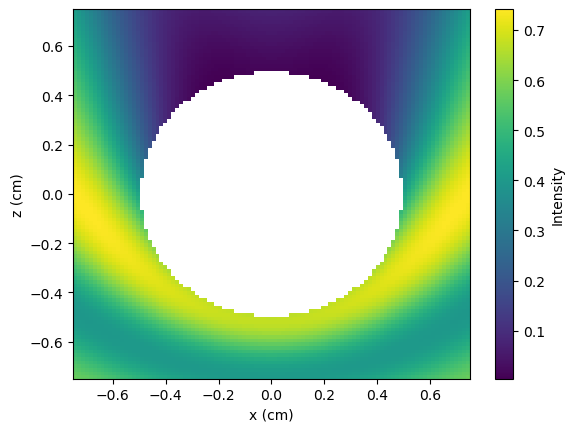

In [91]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity,
    extent = [x.min() * 100, x.max() * 100, z.min() * 100, z.max() * 100],
    aspect='auto',
    origin='lower',
)
cb = plt.colorbar(cax)
cb.set_label("Intensity")
ax.set_xlabel("x (cm)")
ax.set_ylabel("z (cm)")
plt.show()

In [92]:
theta = np.linspace(0, 2 * np.pi, 301)
radpattern = np.zeros(len(theta))
def compute_radpattern(i):
    return sca.ffamplitude([np.sin(theta[i]), 0, np.cos(theta[i])])
radpattern = Parallel(n_jobs=-1)(
    delayed(compute_radpattern)(i) for i in range(len(theta))
)

In [93]:
radpattern = np.abs(radpattern)**2
radpattern = radpattern / np.max(radpattern) 

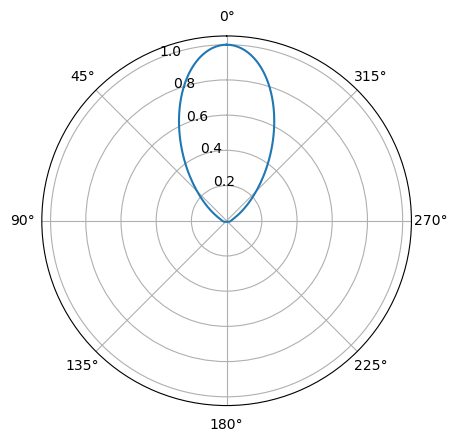

In [96]:
plt.figure()
ax = plt.subplot(111, polar=True) 
ax.plot(theta, radpattern)
ax.set_theta_offset(np.pi / 2)
plt.show()